# Functional Imaging Constrained Diffusion Model

## Setup imports

In [1]:
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler, DDIMScheduler

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import time
import random
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import torch.nn as nn
import torchio as tio
from tqdm.auto import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
num_workers = multiprocessing.cpu_count()
from torchmetrics.functional.image import peak_signal_noise_ratio
from torchmetrics.functional.image import structural_similarity_index_measure

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
c:\Anaconda\envs\pytorch_3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Dataset
MRI_dir = Path('D:/Dataset/ADNI_1_and_2/ADNI_all_classes/nifti_files/CN_nifti')

### SubjectsDataset

In [4]:
MRI_paths = sorted(MRI_dir.glob('*.nii.gz'))

subjects = []
for image_path in MRI_paths:
    PET_path = Path('D:/Dataset/ADNI_ALL/ADNI_info/data/PET_orig_processed_nifti/'+str(image_path)[-17:])
    if os.path.isfile(PET_path) == True:
        subject = tio.Subject(
            mri=tio.ScalarImage(image_path),
            pet=tio.ScalarImage(PET_path)
        )
        subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 293 subjects


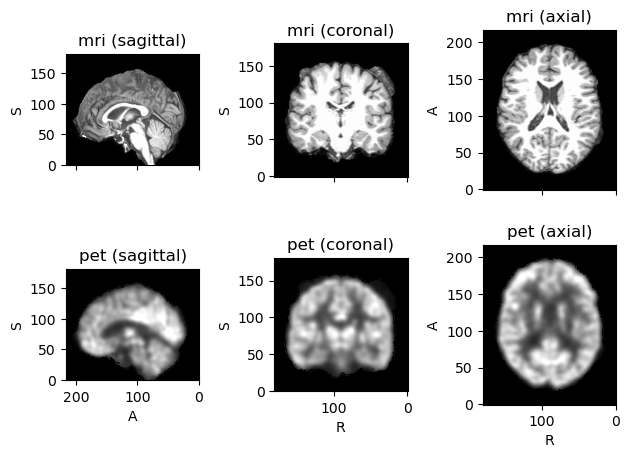

In [5]:
one_subject = dataset[0]
one_subject.plot()

In [6]:
print(one_subject)
print(one_subject.mri)
print(one_subject.pet)

Subject(Keys: ('mri', 'pet'); images: 2)
ScalarImage(shape: (1, 181, 217, 181); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.ByteTensor; memory: 6.8 MiB)
ScalarImage(shape: (1, 181, 217, 181); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.ByteTensor; memory: 6.8 MiB)


In [7]:
# Config
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

## Training a network



In [8]:
training_transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(-1, 1)),
    tio.transforms.Crop([11,10,20,17,0,21]),
    tio.Resize((160, 180, 160))
])

validation_transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(-1, 1)),
    tio.transforms.Crop([11,10,20,17,0,21]),
    tio.Resize((160, 180, 160))
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 263 subjects
Validation set: 30 subjects


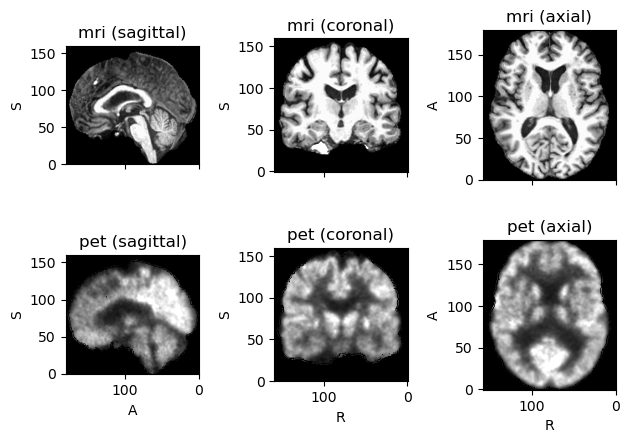

In [9]:
training_instance = training_set[44]
training_instance.plot()

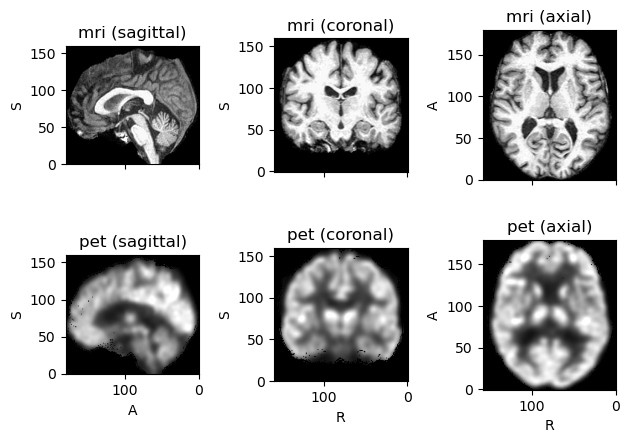

In [10]:
validation_instance = validation_set[24]
validation_instance.plot()

In [11]:
training_batch_size = 2
validation_batch_size = 1

train_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=num_workers,
)

val_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=num_workers,
)

### Visualization of the training images

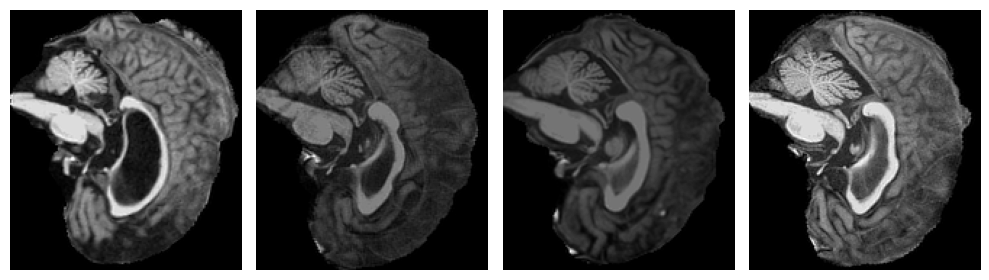

In [12]:
plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(training_set[i * 20]["mri"].data[0, 80, :, :].detach().cpu(), cmap="gray") #, vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

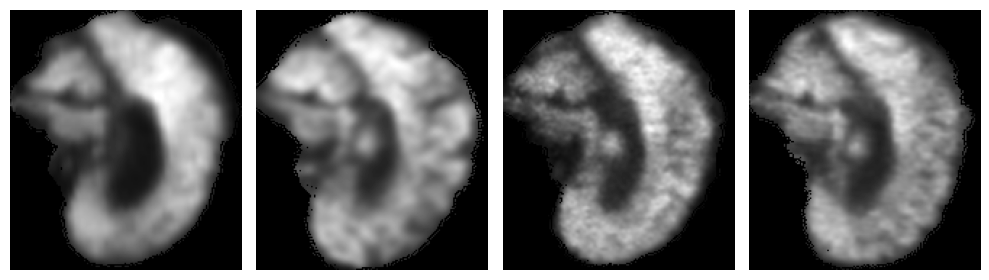

In [13]:
plt.subplots(1, 4, figsize=(10, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(training_set[i * 20]["pet"].data[0, 80, :, :].detach().cpu(), cmap="gray") #, vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Define network, scheduler, optimizer, and inferer

In [14]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    num_channels=[16, 32, 64],
    attention_levels=[False, False, True],
    num_head_channels=[0, 0, 64],
    num_res_blocks=2,
    norm_num_groups=8,
    use_flash_attention=True,
    with_conditioning=True,
    cross_attention_dim=64
)

model.to(device)

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock(
          (norm1): GroupNorm(8, 16, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (time_emb_proj): Linear(in_features=64, out_features=16, bias=True)
          (norm2): GroupNorm(8, 16, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler)

Text(0, 0.5, 'alpha cumprod')

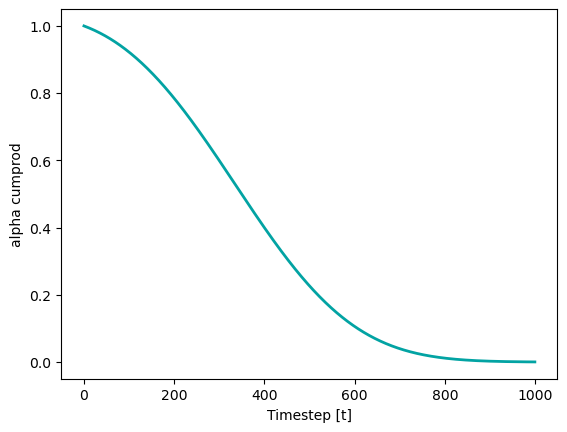

In [15]:
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="scaled_linear_beta", beta_start=0.0005, beta_end=0.0195)
plt.plot(scheduler.alphas_cumprod.cpu(), color=(2 / 255, 163 / 255, 163 / 255), linewidth=2)
plt.xlabel("Timestep [t]")
plt.ylabel("alpha cumprod")

In [16]:
inferer = DiffusionInferer(scheduler)
optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)

In [17]:
def save_checkpoint(model, optimizer, save_path, epoch):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, save_path)

In [18]:
def load_checkpoint(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    return model, optimizer, epoch

## Model training

In this part, we will train the diffusion model to predict the noise added to the images. For this, we are using an MSE loss between the prediction and the original noise. During the training, we are also sampling brain images to evaluate the evolution of the model. In this training, we use Automatic Mixed Precision to save memory and speed up the training.

In [19]:
n_epochs = 50
val_interval = 5
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()
for epoch_ in range(n_epochs):
    epoch = epoch_ + 1
    model.train()
    epoch_loss = 0
    epoch_noise_loss = 0
    epoch_x0_pred_loss = 0
    epoch_psnr = 0
    epoch_ssim = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=160)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        condition = batch["mri"]["data"].to(device)
        images = batch["pet"]["data"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            # print('Generate random noise.')
            noise = torch.randn_like(images).to(device)
            intermediates_pred = torch.randn_like(images).to(device)
            intermediates_true = torch.randn_like(images).to(device)
            x0_pred = torch.randn_like(images).to(device)

            # Create timesteps
            # print('Create timesteps')
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            # print('Get model prediction')
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps, condition=condition) 
            noised_image = scheduler.add_noise(original_samples = images, noise=noise, timesteps=timesteps)
            for n in range (len(noise_pred)):
                intermediates_pred[n,], x0_pred[n] = scheduler.step(torch.unsqueeze(noise_pred[n,:,:,:,:], 0), timesteps[n], torch.unsqueeze(noised_image[n,:,:,:,:], 0))
            noise_loss = F.mse_loss(noise_pred.float(), noise.float())
            x0_pred_loss = F.l1_loss(x0_pred,images)
            loss = noise_loss + x0_pred_loss
            
            PSNR_mid = peak_signal_noise_ratio(x0_pred, images)
            SSIM_mid = structural_similarity_index_measure(x0_pred, images)
            # print("PSNR is: ", str(PSNR.item()))
            # print("SSIM is: ", str(SSIM.item()))

        # print('backward')
        scaler.scale(loss).backward()
        # print('optimizing')
        scaler.step(optimizer)
        # print('updating')
        scaler.update()

        # print('calculating epoch_loss')
        epoch_loss += loss.item()
        epoch_noise_loss += noise_loss.item()
        epoch_x0_pred_loss += x0_pred_loss.item()
        epoch_psnr += PSNR_mid.item()
        epoch_ssim += SSIM_mid.item()
        progress_bar.set_postfix({"noise_loss": epoch_noise_loss / (step + 1), 
                                  "x0_pred_loss": epoch_x0_pred_loss / (step + 1),
                                  "loss": epoch_loss / (step + 1),
                                  "PSNR": epoch_psnr / (step + 1),
                                  "SSIM": epoch_ssim / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))
    
    save_path = 'checkpoints/epoch'+str(epoch)+'_checkpoint.pt'
    save_checkpoint(model, optimizer, save_path, epoch)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 1:   0%|                                                                                                                          | 0/132 [00:00<?, ?it/s]

## Sampling Brain Image

#### Epoch 49 with different seeds

MRI subject  ['D:\\Dataset\\ADNI_1_and_2\\ADNI_all_classes\\nifti_files\\CN_nifti\\036_S_1023.nii.gz']
PET subject  ['D:\\Dataset\\ADNI_ALL\\ADNI_info\\data\\PET_orig_processed_nifti\\036_S_1023.nii.gz']
epoch49_val_036_S_1023_seed0_output.pt


100%|██████████| 1000/1000 [09:46<00:00,  1.70it/s]


Model output


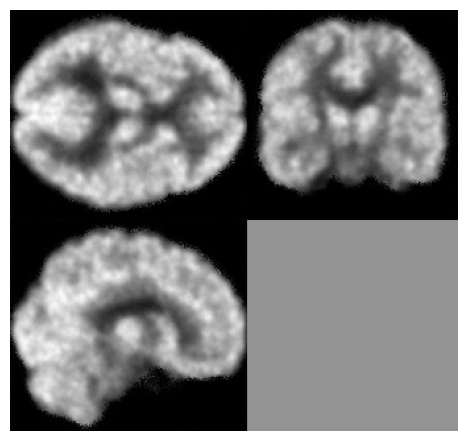

Ground truth


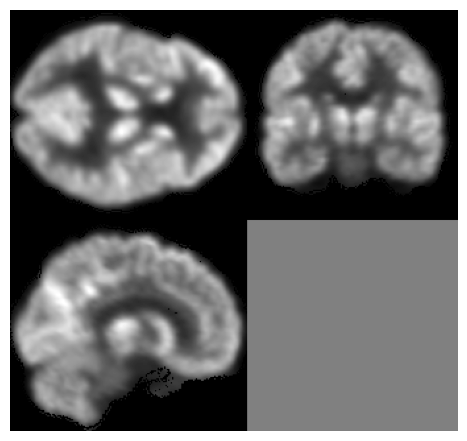

Input MRI


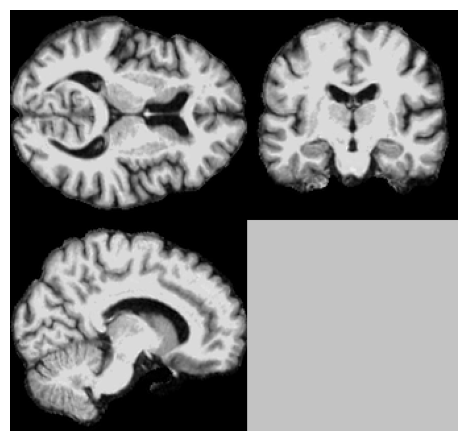

<Figure size 640x480 with 0 Axes>

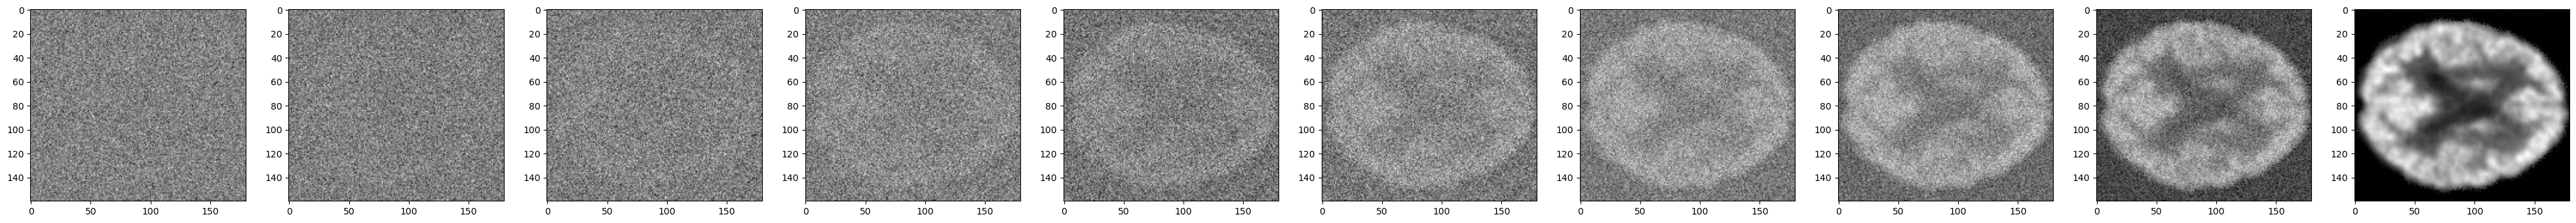

In [20]:
epoch_to_load = 49
load_path = 'checkpoints/epoch'+str(epoch_to_load)+'_checkpoint.pt'
model, optimizer, epoch = load_checkpoint(model, optimizer, load_path)
PSNR_all = []
SSIM_all = []
sbj_ids = []

for step, batch in enumerate(val_loader):
    for seed in range (10):
        if seed == 0 and step == 0: # generate one output to show an example
            SEED =seed
            torch.manual_seed(SEED)
            print('MRI subject ',batch["mri"]["path"])
            print('PET subject ',batch["pet"]["path"])
            sbj_ids.append(batch["mri"]["stem"])
            condition = batch["mri"]["data"].to(device)
            ground_truth = batch["pet"]["data"].to(device)
            
            input_noise = torch.randn((1, 1, 160, 180, 160))
            input_noise = input_noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            print('epoch'+str(epoch_to_load)+'_'+'val_'+str(batch["pet"]["stem"][0])+'_seed'+str(SEED)+'_output.pt')
            with autocast(enabled=True):
                pred_PET, intermediates = inferer.sample(input_noise=input_noise, 
                            diffusion_model=model, 
                            scheduler=scheduler, 
                            save_intermediates=True,
                            intermediate_steps=100,
                            conditioning=torch.unsqueeze(condition[0,:,:,:,:], 0))
            
            print("Model output")
            plt.style.use("default")
            plotting_image_0 = np.concatenate([pred_PET[0, 0, :, :, 80].cpu(), np.flipud(pred_PET[0, 0, :, 90, :].cpu().T)], axis=1)
            plotting_image_1 = np.concatenate([np.flipud(pred_PET[0, 0, 90, :, :].cpu().T), np.zeros((160, 160))], axis=1)
            plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()
            
            print("Ground truth")
            plt.style.use("default")
            plotting_image_0 = np.concatenate([ground_truth[0, 0, :, :, 80].cpu(), np.flipud(ground_truth[0, 0, :, 90, :].cpu().T)], axis=1)
            plotting_image_1 = np.concatenate([np.flipud(ground_truth[0, 0, 90, :, :].cpu().T), np.zeros((160, 160))], axis=1)
            plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()
            
            print("Input MRI")
            plt.style.use("default")
            plotting_image_0 = np.concatenate([condition[0, 0, :, :, 80].cpu(), np.flipud(condition[0, 0, :, 90, :].cpu().T)], axis=1)
            plotting_image_1 = np.concatenate([np.flipud(batch["mri"]["data"][0, 0, 90, :, :].cpu().T), np.zeros((160, 160))], axis=1)
            plt.imshow(np.concatenate([plotting_image_0, plotting_image_1], axis=0), cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()
            
            plt.figure()
            f, axarr = plt.subplots(1,10, figsize=(50, 50)) 
            for i in range (10):
                axarr[i].imshow(intermediates[i][0, 0, :, :, 90].cpu(), cmap="gray")
            plt.show()
            
            torch.save(pred_PET, 'epoch'+str(epoch_to_load)+'_'+'val_'+str(batch["pet"]["stem"][0])+'seed'+str(SEED)+'_output.pt')